### 운송 최적화

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [8]:
df_tc = pd.read_csv('trans_cost.csv', index_col="공장") # 운송 비용
df_tc.head()

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [9]:
df_demand = pd.read_csv('demand.csv') # 공장의 최소수요
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


In [10]:
df_supply = pd.read_csv('supply.csv') # 창고의 최대 공급량
df_supply.head()

,W1,W2,W3
0,35,41,42


In [7]:
# 데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_tc.head()
df_demand = pd.read_csv('demand.csv')
df_demand.head()
df_supply = pd.read_csv('supply.csv')

# 초기 설정
np.random.seed(1)
nw = len(df_tc.index) # 창고 개수 : 3
nf = len(df_tc.columns) # 공장 개수 : 4
pr = list(product(range(nw), range(nf))) # product함수는 W(0~2)와 F(0~3)넘버를 중복없이 짝지음 (0,0)~(2,3)

#수리 모델 작성
m1 = model_min() # 최소화를 실행하는 모델, 정의하는 목적함수를 제약 조건 하에서 최소화 가능
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw): # 창고별 총 공급량 최대 공급량
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf): # 공장별 총 수요량 공장에서 필요하는 최소수요
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
# 공장이 제조할 제품 수요량을 만족시키고 창고가 제공할 부품이 제공 한계를 넘지않도록 제약 조건
m1.solve()

# 총 운송 비용 계산, 최적해(운송비용 최소하는 운송량), 최적값 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x) # 구해진 최적해(v1)
    total_cost += df_tc.iloc[i][j]*value(x) # 최적화 이후 총 비용값(원래비용 * 최적해(v1) = 최적값)
print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))


    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


### 최적의 운송 경로를 네트워크 가시화

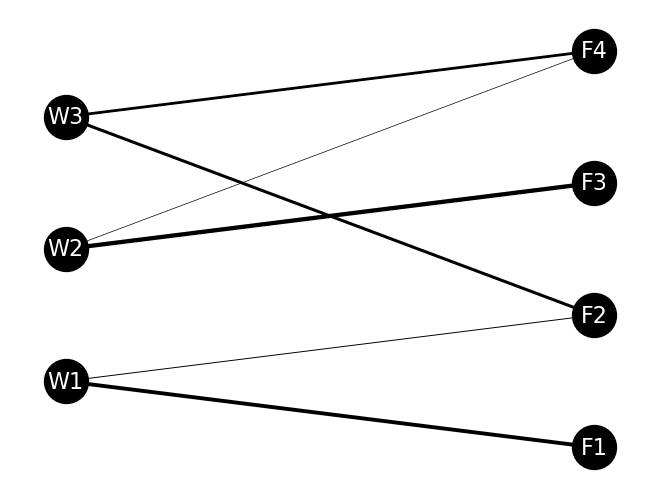

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 & 엣지의 가중치 리스트화
for i in range(0, 3):
    for j in range(3, len(df_pos.columns)):
        G.add_edge(df_pos.columns[i], df_pos.columns[j]) # W - F 를 하나씩 다 연결

# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i] # 0:W1, 1:W2, 2:W3... 6:F4
    pos[node] = (df_pos[node][0],df_pos[node][1]) # df_pos[df_pos.columns[3]][0],df_pos[df_pos.columns[3]][1] = 4.0 0.5

    
# 가중치 부여
sy=[]
size=0.1
for i in range(len(df_tr.index)): # 3개 0,1,2
    for j in range(len(df_tr.columns)): # 4개 0,1,2,3
        sy.append(df_tr.iloc[i,j]*size) # df_tr[0,0]*0.1, df_tr[0,1]*size, df_tr[0,2]*size,...df_tr[2,3]




# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width = sy)

# 표시
plt.show()

In [16]:
df_pos.head()

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


In [25]:
print(df_pos[df_pos.columns[3]][0],df_pos[df_pos.columns[3]][1])

4.0 0.5


In [32]:
print(df_tr.iloc[2,3])

20


### 최적 운송 경로가 제약 조건을 만족하는지 확인

In [33]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 제약조건 계산함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)): # 0,1,2,3
        temp_sum = sum(df_tr[df_demand.columns[i]]) # df_tr 1,2,3열 다 더함
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


In [38]:
print(df_demand.iloc[0][3])

25


In [39]:
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


### 생산 계획 데이터 불러오기

In [58]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material) # 3종류 원료의 비율 ex 제품1에 들어간 원료1,2,3이 1:4:3(개)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit) # 판매가격 - 판매원가
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock) # 각 원료의 재고
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan) # 제품의 생산량

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


### 이익을 계산하는 함수

In [48]:
def product_plan(df_profit,df_plan):
    profit=0
    for i in range(len(df_profit.index)):#0,1
        for j in range(len(df_plan.columns)):#1개
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
        return profit
print("총 이익:"+str(product_plan(df_profit,df_plan)))
#제품 1만 계산한 것

총 이익:80.0


### 목적함수와 제약함수를 통한 최적값찾기

In [78]:
# import pandas as pd
# from pulp import LpVariable, lpSum, value
# from ortoolpy import model_max, addvars, addvals


# m2 = model_max() # 목적함수 - 이익 최대화가 목적
# v2 = {(i) : LpVariable('v%d'%(i), lowBound = 0) for i in range(len(df_profit))}
# print(v2)

# #m2에 제약조건을 추가

# # 각 제품별 이익*생산량
# m2 += lpSum(df_profit.iloc[i] * v2[i] for i in range(len(df_profit)))

# # 제약 조건
# for j in range(len(df_material.columns)): # j: 원료 0,1,2 / i: 제품 0,1
#     m2 += lpSum(df_material.iloc[i,j] * v2[i] for i in range(len(df_profit))) <= df_stock.iloc[:,i]
#     # 제약 조건: 각 제품에 필요한 생산량*원료합 <= 최대 원료 재고량
# m2.solve() # 최적해 구해

# df_plan_sol = df_plan.copy()
# display(df_plan_sol) # 원래 생산계획

# for k, x in v2.items():
#     df_plan_sol.iloc[k] = value(x) # v2 최적해
# display(df_plan_sol) # 최적으로 찾아낸 생산계획 (생산량)

import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals


df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit))) # i:0,1
for i in range(len(df_material.columns)):# 0,1,2
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]# stock:40,80,50
m.solve()
# 
df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익:95.0


In [90]:
print(df_material.iloc[0,0])

1


### 최적의 조건이 제약조건을 만족하나?

In [91]:
display(df_material, df_stock, df_plan) # df_m : 제품에 사용되는 원료비율, df_s:원료 재고량, df_plan:현재 제품 생산량

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


,원료1,원료2,원료3
항목,,,
재고,40,80,50


,생산량
제품,
제품1,16
제품2,0


In [95]:
# 제약조건으로 규정한 각 원료의 사용량이 재고를 효율적으로 이용하고 있나

def cond_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns)) # 초기값
    
    for i in range(len(df_material.columns)): # i: 원료(0,1,2)
        temp_sum = 0
        for j in range(len(df_material.index)): #j : 제품(0,1)
            # 각 원료에 대해 제품의 생산량*사용량 => temp_sum: 각 원료 총 사용량
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + ' 사용량: ' + str(temp_sum) + ', 재고:' + str(float(df_stock.iloc[0][i])))
    return flag
            
cond_stock(df_plan, df_material, df_stock)       

원료1 사용량: 16.0, 재고:40.0
원료2 사용량: 64.0, 재고:80.0
원료3 사용량: 48.0, 재고:50.0


array([1., 1., 1.])

In [92]:
print(len(df_material.columns))

3
